In [43]:
# Install required libraries
!pip install alpha_vantage
!pip install yfinance
!pip install snscrape
!pip install transformers
!pip install tweepy
!pip install matplotlib
!pip install seaborn

# Import necessary libraries
import os
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import tweepy

In [44]:
import os

# Set your Alpha Vantage API key as an environment variable
os.environ['ALPHA_VANTAGE_API_KEY'] = 'Z64TQIR6X6KQ04SI'

In [45]:
from alpha_vantage.timeseries import TimeSeries

# Initialize the TimeSeries class with your API key
api_key = os.getenv('ALPHA_VANTAGE_API_KEY')
ts = TimeSeries(key=api_key, output_format='pandas')

# Fetch daily stock data for NVIDIA (NVDA)
data, meta_data = ts.get_daily(symbol='NVDA', outputsize='full')

# Reset the index to have 'date' as a column
data.reset_index(inplace=True)

# Rename columns for easier access
data.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Display the first few rows of the cleaned dataframe
print(data.head())

        date    open    high       low   close       volume
0 2024-08-02  103.76  108.72  101.3700  107.27  482027464.0
1 2024-08-01  117.53  120.16  106.8104  109.21  523462326.0
2 2024-07-31  112.90  118.34  110.8800  117.02  473174182.0
3 2024-07-30  111.52  111.99  102.5400  103.73  486833274.0
4 2024-07-29  113.69  116.28  111.3000  111.59  248152068.0


In [46]:
!pip install tweepy --upgrade

In [47]:
import tweepy

# Twitter API credentials
bearer_token = 'AAAAAAAAAAAAAAAAAAAAABTbuQEAAAAAE%2Ff9e96Vqb37D7cle%2FEGX5LCp9I%3DS5wBBP8x8Y8Bgcjyj40cweXBwMDg5rTChtGm0JNm6i7YOi21uM'

# Set up tweepy client with bearer token
client = tweepy.Client(bearer_token=bearer_token)

In [48]:
!pip install praw

In [49]:
pip install asyncpraw

In [50]:
import asyncio
import asyncpraw
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Reddit API credentials
client_id = 'pIziTCg_rXHiPxqzDGLD5A'
client_secret = '98bOZRhkg5U-nxeTidU1ns8ocWc-qw'
user_agent = 'SentimentAnalysis'  # A user agent that uniquely identifies your app

# Initialize asyncpraw with the credentials
reddit = asyncpraw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)


In [51]:
# Function to fetch Reddit posts and comments asynchronously
async def fetch_reddit_posts(subreddit, query, limit=100):
    posts = []
    subreddit = await reddit.subreddit(subreddit)
    async for submission in subreddit.search(query, limit=limit):
        posts.append(submission.title + " " + submission.selftext)
        # Check if submission has comments before trying to replace_more
        if submission.comments:
          await submission.comments.replace_more(limit=0)
          for comment in submission.comments.list():
              posts.append(comment.body[:510])
    return posts

In [52]:

from aiohttp import ClientError

# Function to fetch Reddit posts with retry mechanism
async def fetch_reddit_posts_with_retry(subreddit, query, limit=100, retries=3):
    attempt = 0
    while attempt < retries:
        try:
            posts = await fetch_reddit_posts(subreddit, query, limit)
            return posts
        except (ClientError, asyncio.TimeoutError) as e:
            print(f"Network error occurred: {e}. Retrying... ({attempt+1}/{retries})")
            attempt += 1
            await asyncio.sleep(2 ** attempt)  # Exponential backoff
    raise Exception("Failed to fetch posts after several attempts")

# Define the subreddit and query
subreddit = 'stocks'  # Replace with the desired subreddit
query = 'NVIDIA'  # Replace with the desired search query
# Example usage
reddit_posts = await fetch_reddit_posts_with_retry(subreddit, query, limit=100)

In [53]:
#Handling Rate Limits

async def fetch_reddit_posts_with_rate_limit(subreddit, query, limit=100):
    try:
        posts = await fetch_reddit_posts_with_retry(subreddit, query, limit)
        return posts
    except Exception as e:
        if 'ratelimit' in str(e).lower():
            print("Rate limit exceeded. Sleeping before retrying...")
            await asyncio.sleep(60)  # Sleep for 60 seconds
            return await fetch_reddit_posts_with_retry(subreddit, query, limit)

NVIDIA Will Crash So one thing that most people agree on is that Nvidia is the one benefitting from this Gold Rush ( AI Boom) being the most dominant player selling shovels ( GPU's).

But my thesis is that this AI Boom isn't sustainable for long since it is not only expensive to afford the infrastructure for machine learning( data centres etc) but also time consuming to train the machines with a googol of information.

 Now, the problem is that currently there aren't meaningful profitable applications for these AI, especially generative AI which all the companies seem to be hopping on now just for the sake of it. It would make sense if they used this AI to enhance their products which many are but offerring generative AI as a service directly to the consumers still seems to be somewhat precarious. Most common people don't care about AI. The problem that most people are callous about is the over dependence of NVIDIA on this Generative AI Boom to the point where more than 60% of their re

<ipython-input-54-ef4ab6f3bfb3>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


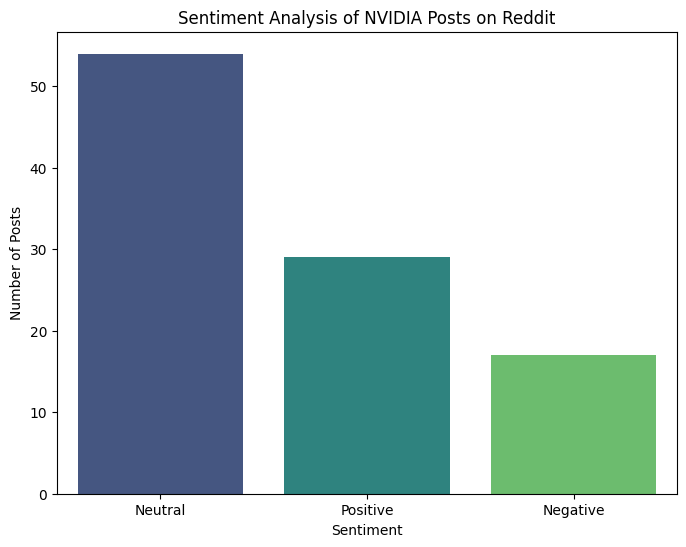

In [54]:
# Asynchronous main function
async def main():
    subreddit = 'stocks'
    query = 'NVIDIA'
    reddit_posts = await fetch_reddit_posts(subreddit, query, limit=100)

    # Display fetched posts
    for post in reddit_posts[:10]:
        print(post)

    # Load pre-trained FinBERT model for sentiment analysis
    sentiment_pipeline = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone", truncation=True,max_length=512)

    # Analyze sentiment of Reddit posts
    sentiments = sentiment_pipeline(reddit_posts)

    # Prepare data for visualization
    sentiment_scores = [{'post': post, 'sentiment': sentiment['label']} for post, sentiment in zip(reddit_posts, sentiments)]
    sentiment_df = pd.DataFrame(sentiment_scores)

    # Display sentiments
    for post, sentiment in zip(reddit_posts, sentiments):
        print(f"Post: {post}\nSentiment: {sentiment['label']}\n")

    # Count the occurrences of each sentiment
    sentiment_counts = sentiment_df['sentiment'].value_counts()

    # Plot the sentiment distribution
    plt.figure(figsize=(8, 6))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
    plt.title('Sentiment Analysis of NVIDIA Posts on Reddit')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Posts')
    plt.show()

# Use await to call the main function instead of asyncio.run()
await main()